# Restored loss weights to default
# Updated the learning rate for generator to half of discriminator
# Added in noisy sample weights

# Updated tuning factor to 10--- other machine is 100.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"
'''
Note that I am manually splitting across GPUs...
'''
#720x1440
im_rows = 360#272#408#270
im_cols = 720#480#720#480
nb_resnet = 6 # The default was 9 modules




# example of defining a 70x70 patchgan discriminator model
import tensorflow as tf
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D, Conv2DTranspose, Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model
import numpy as np
# example of an encoder-decoder generator for the cyclegan


# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

 
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(1, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model
 


/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [2]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread('/home/tkyono/Desktop/datasets/sim2real/testB/VH002_021-01_3_031950.jpg')
plt.figure(figsize=(24, 12))
plt.imshow(im[100:820, 200:1640], cmap = 'gray')
plt.show()

<Figure size 2400x1200 with 1 Axes>

In [3]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0001, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

# input shape
image_shape = (im_rows,im_cols,1)
# generator: A -> B
with tf.device('/device:GPU:2'):
    g_model_AtoB = define_generator(image_shape, nb_resnet)
# generator: B -> A
with tf.device('/device:GPU:3'):
    g_model_BtoA = define_generator(image_shape, nb_resnet)
# discriminator: A -> [real/fake]
with tf.device('/device:GPU:2'):
    d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
with tf.device('/device:GPU:3'):
    d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
with tf.device('/device:GPU:2'):
    c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
with tf.device('/device:GPU:3'):
    c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


W1209 15:44:07.060401 139648150996800 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1209 15:44:07.061934 139648150996800 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1209 15:44:07.065012 139648150996800 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1209 15:44:07.841327 139648150996800 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [4]:
import random
def generate_real_samples(dataset, n_samples, y_patch, x_patch):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    #y = np.ones((n_samples, y_patch, x_patch, 1))
    y = (np.random.rand(n_samples, y_patch, x_patch, 1) + 9) / 10.0
    return X, y

def generate_fake_samples(g_model, dataset, y_patch, x_patch):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    #y= np.zeros((len(X), y_patch, x_patch, 1))
    y = np.random.rand(len(X), y_patch, x_patch, 1) / 10.0
    return X, y


# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif np.random.random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 1
    # determine the output square shape of the discriminator
    y_patch = d_model_A.output_shape[1]
    x_patch = d_model_A.output_shape[2]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainB) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    
    g_loss1 = 0
    dA_loss1 = 1e6
    dA_loss2 = 1e6
    g_loss2 = 0
    dB_loss1 = 1e6
    dB_loss2 = 1e6
    factor = 10
    
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, y_patch, x_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, y_patch, x_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, y_patch, x_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, y_patch, x_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        #print(X_realB.shape, y_realA.shape, X_realA.shape, X_realB.shape, X_realA.shape)
        
        
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        if g_loss2 < (100 * dA_loss1) and g_loss2 < (100 * dA_loss2):
            # update discriminator for A -> [real/fake]
            dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
                  
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        
        if g_loss1 < (100 * dB_loss1) and g_loss1 < (100 * dB_loss2): 
            # update discriminator for B -> [real/fake]
            dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        
        # summarize performance
        if i % bat_per_epo == 0:
            r = random.randint(0, 100)
            pred = g_model_AtoB.predict(np.expand_dims(testA[r,:,:], 0))
            plt.figure()
            plt.imshow(np.squeeze(normalize(pred[0])))
            plt.show()
            plt.figure()
            plt.imshow(np.squeeze(normalize(testA[r])))
            plt.show()
            print("Saving file: " + 'AtoB_' + str(int(i / bat_per_epo)) + '.h5')
            g_model_AtoB.save('AtoB_' + str(int(i / bat_per_epo)) + '.h5')
        if i % 100 == 0:
            print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

In [ ]:
import glob, os
import cv2
import matplotlib.pyplot as plt
os.chdir("/home/tkyono/Desktop/datasets/sim2real/")

def normalize(A):
    return (A - np.min(A))/ np.ptp(A)

def standardize(A):
    return np.expand_dims((normalize(cv2.resize(A[100:820, 200:1640], (im_cols, im_rows))) * 2) - 1 , -1)

trainA = []
for file in glob.glob("trainA/*.jpg"):
    trainA.append(standardize(cv2.imread(file, 0)))
trainA = np.array(trainA)
print("Loaded Train A")

trainB = []
for file in glob.glob("trainB/*.jpg"):
    trainB.append(standardize(cv2.imread(file, 0)))
trainB = np.array(trainB)
print("Loaded Train B")
testA = []
for file in glob.glob("testA/*.jpg"):
    testA.append(standardize(cv2.imread(file, 0)))
testA = np.array(testA)
print("Loaded Test A")
testB = []
for file in glob.glob("testB/*.jpg"):
    testB.append(standardize(cv2.imread(file, 0)))
testB = np.array(testB)
print("Loaded Test B")

Loaded Train A
Loaded Train B
Loaded Test A
Loaded Test B


W1209 15:44:55.260227 139648150996800 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1209 15:44:55.261440 139648150996800 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

/usr/lib/python3/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/lib/python3/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weight

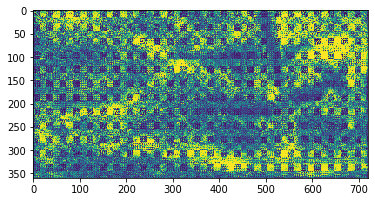

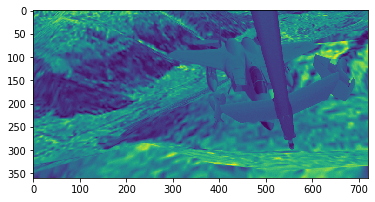

Saving file: AtoB_0.h5
>1, dA[0.659,1.904] dB[1.138,1.035] g[16.646,16.385]
>101, dA[0.218,0.205] dB[0.124,0.242] g[5.998,7.639]
>201, dA[0.161,0.139] dB[0.134,0.069] g[2.825,3.286]
>301, dA[0.151,0.031] dB[0.025,0.096] g[4.148,4.490]
>401, dA[0.020,0.148] dB[0.025,0.096] g[3.988,4.099]
>501, dA[0.020,0.148] dB[0.019,0.081] g[3.796,4.271]
>601, dA[0.020,0.148] dB[0.019,0.081] g[3.550,4.595]
>701, dA[0.020,0.148] dB[0.019,0.081] g[3.156,3.005]
>801, dA[0.020,0.148] dB[0.019,0.081] g[2.799,3.193]
>901, dA[0.020,0.148] dB[0.123,0.107] g[3.346,3.979]
>1001, dA[0.109,0.029] dB[0.020,0.098] g[3.985,3.915]
>1101, dA[0.077,0.223] dB[0.201,0.108] g[3.095,3.592]
>1201, dA[0.054,0.109] dB[0.222,0.141] g[3.149,3.379]
>1301, dA[0.031,0.022] dB[0.037,0.122] g[3.979,5.235]
>1401, dA[0.121,0.085] dB[0.017,0.025] g[1.941,2.127]
>1501, dA[0.077,0.085] dB[0.017,0.025] g[3.800,4.592]
>1601, dA[0.132,0.024] dB[0.141,0.054] g[4.531,4.380]
>1701, dA[0.021,0.123] dB[0.128,0.023] g[2.862,2.668]
>1801, dA[0.161

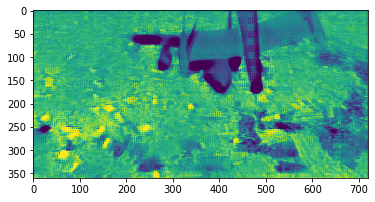

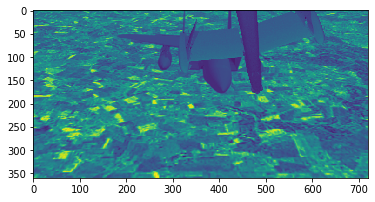

Saving file: AtoB_1.h5
>2301, dA[0.017,0.103] dB[0.014,0.046] g[2.315,2.782]
>2401, dA[0.017,0.103] dB[0.014,0.046] g[2.478,2.465]
>2501, dA[0.171,0.067] dB[0.014,0.046] g[1.859,2.421]
>2601, dA[0.048,0.008] dB[0.014,0.046] g[2.397,2.541]
>2701, dA[0.048,0.008] dB[0.014,0.046] g[1.647,2.065]
>2801, dA[0.048,0.008] dB[0.014,0.046] g[3.310,4.383]
>2901, dA[0.048,0.008] dB[0.025,0.130] g[2.119,2.288]
>3001, dA[0.048,0.008] dB[0.131,0.177] g[1.877,2.397]
>3101, dA[0.048,0.008] dB[0.014,0.259] g[2.758,2.900]
>3201, dA[0.048,0.008] dB[0.014,0.259] g[6.516,5.013]
>3301, dA[0.048,0.008] dB[0.132,0.051] g[3.295,2.605]
>3401, dA[0.048,0.008] dB[0.096,0.012] g[3.677,4.602]
>3501, dA[0.048,0.008] dB[0.096,0.012] g[5.001,4.905]
>3601, dA[0.048,0.008] dB[0.096,0.012] g[2.386,2.555]
>3701, dA[0.048,0.008] dB[0.096,0.012] g[1.851,1.868]
>3801, dA[0.048,0.008] dB[0.096,0.012] g[1.887,1.720]
>3901, dA[0.048,0.008] dB[0.096,0.012] g[4.330,3.396]
>4001, dA[0.048,0.008] dB[0.096,0.012] g[1.883,2.142]
>4101

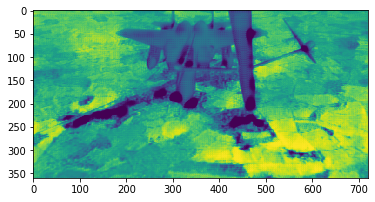

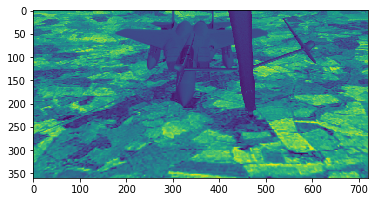

Saving file: AtoB_2.h5
>4501, dA[0.048,0.008] dB[0.096,0.011] g[1.314,1.781]
>4601, dA[0.048,0.008] dB[0.096,0.011] g[2.672,2.744]
>4701, dA[0.048,0.008] dB[0.096,0.011] g[2.971,3.507]
>4801, dA[0.048,0.008] dB[0.096,0.011] g[5.212,4.217]
>4901, dA[0.048,0.008] dB[0.096,0.011] g[1.418,1.727]
>5001, dA[0.048,0.008] dB[0.096,0.011] g[1.949,2.143]
>5101, dA[0.048,0.008] dB[0.096,0.011] g[3.884,5.166]
>5201, dA[0.048,0.008] dB[0.049,0.078] g[2.223,2.250]
>5301, dA[0.048,0.008] dB[0.042,0.021] g[2.821,2.866]
>5401, dA[0.048,0.008] dB[0.214,0.168] g[2.299,2.295]
>5501, dA[0.048,0.008] dB[0.014,0.036] g[1.974,2.107]
>5601, dA[0.048,0.008] dB[0.029,0.015] g[2.481,2.854]
>5701, dA[0.048,0.008] dB[0.029,0.035] g[2.413,2.405]
>5801, dA[0.048,0.008] dB[0.084,0.011] g[6.321,5.501]
>5901, dA[0.048,0.008] dB[0.084,0.011] g[2.120,1.931]
>6001, dA[0.048,0.008] dB[0.084,0.011] g[5.880,4.558]
>6101, dA[0.048,0.008] dB[0.084,0.011] g[5.089,3.815]
>6201, dA[0.048,0.008] dB[0.024,0.012] g[6.173,4.686]
>6301

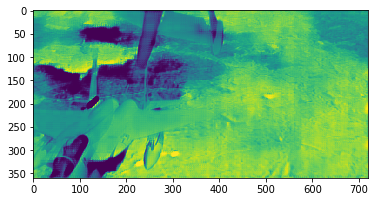

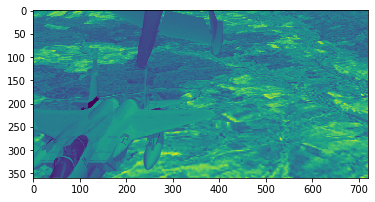

Saving file: AtoB_3.h5
>6701, dA[0.048,0.008] dB[0.032,0.011] g[1.633,1.773]
>6801, dA[0.048,0.008] dB[0.032,0.011] g[1.686,1.618]
>6901, dA[0.048,0.008] dB[0.032,0.011] g[1.412,1.333]
>7001, dA[0.048,0.008] dB[0.154,0.117] g[3.584,3.887]
>7101, dA[0.048,0.008] dB[0.012,0.284] g[2.099,1.966]
>7201, dA[0.048,0.008] dB[0.012,0.284] g[2.274,1.969]
>7301, dA[0.048,0.008] dB[0.058,0.013] g[1.530,1.491]
>7401, dA[0.048,0.008] dB[0.017,0.051] g[1.393,1.122]
>7501, dA[0.048,0.008] dB[0.008,0.142] g[1.990,2.318]
>7601, dA[0.048,0.008] dB[0.008,0.142] g[2.528,3.392]
>7701, dA[0.048,0.008] dB[0.008,0.142] g[2.220,2.906]
>7801, dA[0.048,0.008] dB[0.008,0.142] g[1.455,1.980]
>7901, dA[0.048,0.008] dB[0.008,0.142] g[1.691,2.064]
>8001, dA[0.048,0.008] dB[0.008,0.142] g[1.394,1.699]
>8101, dA[0.048,0.008] dB[0.008,0.142] g[1.978,2.402]
>8201, dA[0.048,0.008] dB[0.008,0.142] g[5.536,4.552]
>8301, dA[0.048,0.008] dB[0.008,0.142] g[3.341,4.216]
>8401, dA[0.048,0.008] dB[0.008,0.142] g[1.516,1.588]
>8501

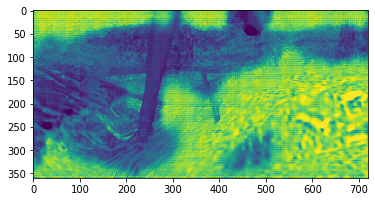

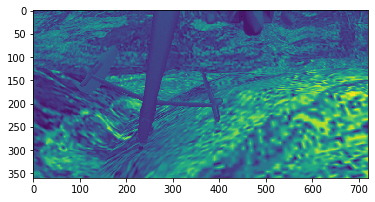

Saving file: AtoB_4.h5
>8901, dA[0.048,0.008] dB[0.008,0.142] g[2.411,2.348]
>9001, dA[0.048,0.008] dB[0.008,0.142] g[4.442,4.438]
>9101, dA[0.048,0.008] dB[0.008,0.142] g[1.110,1.423]
>9201, dA[0.048,0.008] dB[0.008,0.142] g[1.259,1.665]
>9301, dA[0.048,0.008] dB[0.008,0.142] g[1.220,1.483]
>9401, dA[0.048,0.008] dB[0.008,0.142] g[1.369,1.836]
>9501, dA[0.048,0.008] dB[0.008,0.142] g[1.258,1.542]
>9601, dA[0.048,0.008] dB[0.008,0.142] g[1.056,1.484]
>9701, dA[0.048,0.008] dB[0.008,0.142] g[1.656,1.926]
>9801, dA[0.048,0.008] dB[0.020,0.015] g[5.351,6.722]
>9901, dA[0.048,0.008] dB[0.017,0.011] g[1.396,1.530]
>10001, dA[0.048,0.008] dB[0.063,0.140] g[1.447,1.162]
>10101, dA[0.048,0.008] dB[0.091,0.095] g[1.344,1.391]
>10201, dA[0.048,0.008] dB[0.016,0.067] g[4.414,3.681]
>10301, dA[0.048,0.008] dB[0.079,0.012] g[2.002,1.579]
>10401, dA[0.048,0.008] dB[0.015,0.067] g[1.676,1.755]
>10501, dA[0.048,0.008] dB[0.015,0.118] g[1.890,1.727]
>10601, dA[0.048,0.008] dB[0.020,0.031] g[1.576,1.325

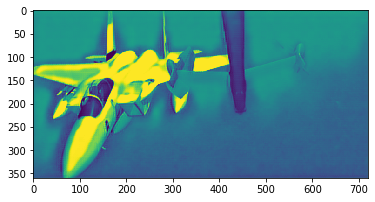

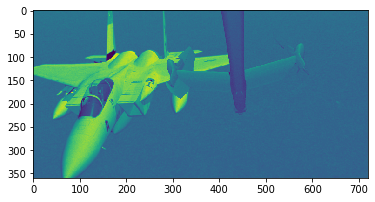

Saving file: AtoB_5.h5
>11101, dA[0.048,0.008] dB[0.101,0.011] g[1.506,1.391]
>11201, dA[0.048,0.008] dB[0.063,0.014] g[3.586,2.951]
>11301, dA[0.048,0.008] dB[0.053,0.013] g[1.841,2.105]
>11401, dA[0.048,0.008] dB[0.012,0.063] g[1.774,1.646]
>11501, dA[0.048,0.008] dB[0.079,0.012] g[3.434,3.073]
>11601, dA[0.048,0.008] dB[0.085,0.247] g[1.341,2.261]
>11701, dA[0.048,0.008] dB[0.052,0.067] g[1.511,1.014]
>11801, dA[0.048,0.008] dB[0.082,0.012] g[2.021,1.554]
>11901, dA[0.048,0.008] dB[0.018,0.028] g[3.244,3.129]
>12001, dA[0.048,0.008] dB[0.391,0.056] g[1.794,1.430]
>12101, dA[0.048,0.008] dB[0.019,0.030] g[4.358,3.239]
>12201, dA[0.048,0.008] dB[0.010,0.052] g[3.036,2.730]
>12301, dA[0.048,0.008] dB[0.010,0.052] g[1.428,1.491]
>12401, dA[0.048,0.008] dB[0.010,0.052] g[2.788,3.454]
>12501, dA[0.048,0.008] dB[0.121,0.102] g[2.119,1.808]
>12601, dA[0.048,0.008] dB[0.158,0.009] g[1.072,1.388]
>12701, dA[0.048,0.008] dB[0.009,0.160] g[2.973,2.445]
>12801, dA[0.048,0.008] dB[0.009,0.160] g[

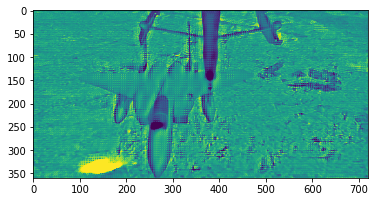

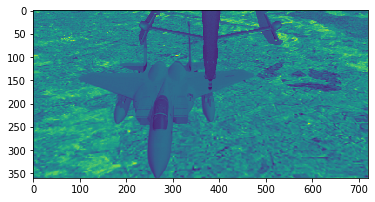

Saving file: AtoB_6.h5
>13301, dA[0.048,0.008] dB[0.009,0.160] g[3.113,3.908]
>13401, dA[0.048,0.008] dB[0.024,0.009] g[3.509,3.615]
>13501, dA[0.048,0.008] dB[0.027,0.089] g[2.777,2.425]
>13601, dA[0.048,0.008] dB[0.013,0.045] g[1.597,1.223]
>13701, dA[0.048,0.008] dB[0.009,0.059] g[1.965,2.023]
>13801, dA[0.048,0.008] dB[0.009,0.059] g[2.164,2.471]
>13901, dA[0.048,0.008] dB[0.009,0.059] g[1.359,1.529]
>14001, dA[0.048,0.008] dB[0.009,0.059] g[1.310,1.462]
>14101, dA[0.048,0.008] dB[0.009,0.059] g[1.785,2.262]
>14201, dA[0.048,0.008] dB[0.125,0.019] g[1.870,1.638]
>14301, dA[0.048,0.008] dB[0.009,0.106] g[1.452,1.833]
>14401, dA[0.048,0.008] dB[0.009,0.106] g[1.749,1.360]
>14501, dA[0.048,0.008] dB[0.009,0.106] g[2.442,2.852]
>14601, dA[0.048,0.008] dB[0.009,0.106] g[1.480,1.541]
>14701, dA[0.048,0.008] dB[0.009,0.106] g[1.231,1.145]
>14801, dA[0.048,0.008] dB[0.161,0.143] g[1.855,1.227]
>14901, dA[0.048,0.008] dB[0.008,0.063] g[1.363,1.425]
>15001, dA[0.048,0.008] dB[0.008,0.063] g[

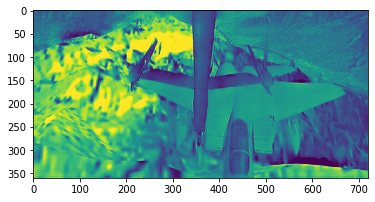

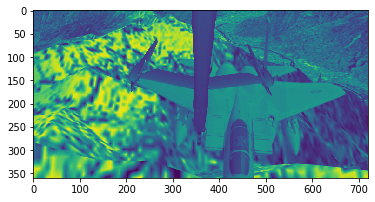

Saving file: AtoB_7.h5
>15501, dA[0.048,0.008] dB[0.009,0.036] g[2.635,2.058]
>15601, dA[0.048,0.008] dB[0.009,0.036] g[2.303,1.913]
>15701, dA[0.048,0.008] dB[0.009,0.036] g[3.104,2.823]
>15801, dA[0.048,0.008] dB[0.042,0.010] g[3.102,2.393]
>15901, dA[0.048,0.008] dB[0.232,0.035] g[3.870,3.103]
>16001, dA[0.048,0.008] dB[0.009,0.028] g[0.935,1.035]
>16101, dA[0.048,0.008] dB[0.009,0.043] g[1.323,0.961]
>16201, dA[0.048,0.008] dB[0.009,0.043] g[3.620,3.386]
>16301, dA[0.048,0.008] dB[0.012,0.140] g[1.856,1.965]
>16401, dA[0.048,0.008] dB[0.010,0.073] g[1.429,1.067]
>16501, dA[0.048,0.008] dB[0.010,0.073] g[1.701,1.934]
>16601, dA[0.048,0.008] dB[0.010,0.073] g[1.471,1.426]
>16701, dA[0.048,0.008] dB[0.009,0.089] g[2.611,1.970]
>16801, dA[0.048,0.008] dB[0.009,0.089] g[1.417,1.466]
>16901, dA[0.048,0.008] dB[0.014,0.070] g[2.159,1.892]
>17001, dA[0.048,0.008] dB[0.084,0.023] g[1.612,2.157]
>17101, dA[0.048,0.008] dB[0.013,0.042] g[1.663,1.266]
>17201, dA[0.048,0.008] dB[0.037,0.007] g[

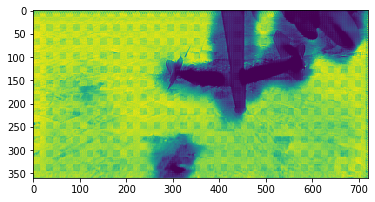

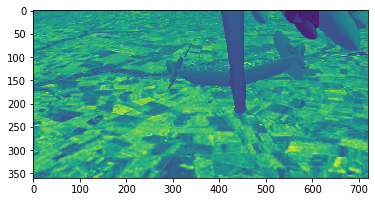

Saving file: AtoB_8.h5
>17701, dA[0.048,0.008] dB[0.037,0.007] g[1.493,1.526]
>17801, dA[0.048,0.008] dB[0.037,0.007] g[1.879,1.682]
>17901, dA[0.048,0.008] dB[0.037,0.007] g[1.292,1.296]
>18001, dA[0.048,0.008] dB[0.037,0.007] g[1.235,1.120]
>18101, dA[0.048,0.008] dB[0.037,0.007] g[1.127,1.056]
>18201, dA[0.048,0.008] dB[0.037,0.007] g[1.152,1.575]
>18301, dA[0.048,0.008] dB[0.037,0.007] g[2.346,3.005]
>18401, dA[0.048,0.008] dB[0.037,0.007] g[0.864,0.955]
>18501, dA[0.011,0.225] dB[0.037,0.007] g[1.227,2.030]
>18601, dA[0.105,0.102] dB[0.037,0.007] g[0.988,1.495]
>18701, dA[0.081,0.063] dB[0.037,0.007] g[1.009,1.843]
>18801, dA[0.104,0.149] dB[0.037,0.007] g[1.091,1.739]
>18901, dA[0.102,0.184] dB[0.037,0.007] g[1.717,1.622]
>19001, dA[0.093,0.055] dB[0.037,0.007] g[0.948,1.446]
>19101, dA[0.115,0.024] dB[0.037,0.007] g[1.569,2.271]
>19201, dA[0.083,0.011] dB[0.037,0.007] g[1.054,1.269]
>19301, dA[0.055,0.011] dB[0.037,0.007] g[1.107,1.318]
>19401, dA[0.015,0.102] dB[0.037,0.007] g[

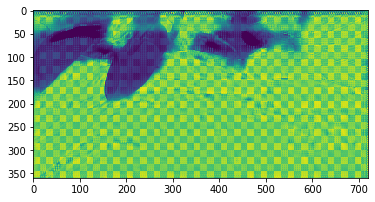

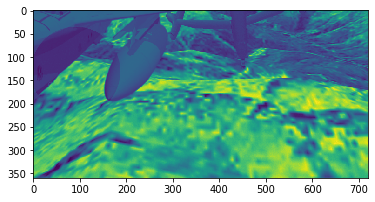

Saving file: AtoB_9.h5
>19901, dA[0.024,0.018] dB[0.037,0.007] g[1.018,1.665]
>20001, dA[0.021,0.008] dB[0.037,0.007] g[1.261,1.474]
>20101, dA[0.021,0.008] dB[0.037,0.007] g[1.050,1.291]
>20201, dA[0.021,0.008] dB[0.037,0.007] g[2.237,1.968]
>20301, dA[0.021,0.008] dB[0.037,0.007] g[1.673,1.613]
>20401, dA[0.021,0.008] dB[0.037,0.007] g[1.023,1.162]
>20501, dA[0.021,0.008] dB[0.037,0.007] g[0.961,1.112]
>20601, dA[0.021,0.008] dB[0.037,0.007] g[0.788,0.850]
>20701, dA[0.021,0.008] dB[0.037,0.007] g[0.973,1.053]
>20801, dA[0.021,0.008] dB[0.037,0.007] g[0.858,1.036]
>20901, dA[0.021,0.008] dB[0.037,0.007] g[0.738,0.855]
>21001, dA[0.290,0.067] dB[0.085,0.023] g[1.845,1.906]
>21101, dA[0.009,0.224] dB[0.027,0.008] g[1.098,1.112]
>21201, dA[0.046,0.317] dB[0.027,0.008] g[0.927,0.840]
>21301, dA[0.096,0.056] dB[0.036,0.008] g[3.368,2.892]
>21401, dA[0.048,0.010] dB[0.036,0.008] g[1.350,1.393]
>21501, dA[0.012,0.104] dB[0.036,0.008] g[1.458,1.900]
>21601, dA[0.036,0.034] dB[0.036,0.008] g[

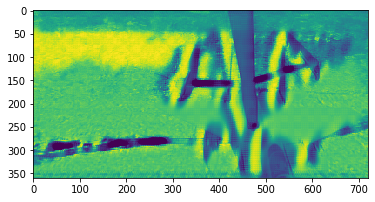

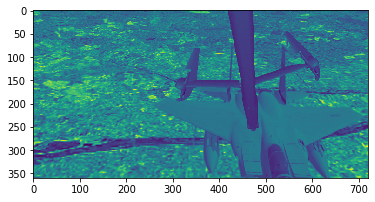

Saving file: AtoB_10.h5
>22101, dA[0.185,0.013] dB[0.036,0.008] g[1.926,2.238]
>22201, dA[0.185,0.102] dB[0.036,0.008] g[2.747,2.266]
>22301, dA[0.026,0.093] dB[0.036,0.008] g[1.149,1.390]
>22401, dA[0.011,0.261] dB[0.036,0.008] g[1.351,1.654]
>22501, dA[0.011,0.108] dB[0.036,0.008] g[1.352,1.364]
>22601, dA[0.006,0.269] dB[0.036,0.008] g[1.371,1.592]
>22701, dA[0.006,0.269] dB[0.036,0.008] g[1.268,1.586]
>22801, dA[0.006,0.269] dB[0.022,0.025] g[1.503,1.234]
>22901, dA[0.006,0.269] dB[0.006,0.011] g[1.385,1.482]
>23001, dA[0.006,0.269] dB[0.006,0.011] g[1.809,1.584]
>23101, dA[0.006,0.269] dB[0.006,0.011] g[0.805,0.877]
>23201, dA[0.006,0.269] dB[0.006,0.011] g[0.996,1.170]
>23301, dA[0.006,0.269] dB[0.006,0.011] g[1.074,1.429]
>23401, dA[0.006,0.269] dB[0.006,0.011] g[2.861,2.272]
>23501, dA[0.006,0.269] dB[0.006,0.011] g[2.377,3.491]
>23601, dA[0.006,0.269] dB[0.006,0.011] g[0.895,1.174]
>23701, dA[0.006,0.269] dB[0.006,0.011] g[1.315,2.307]
>23801, dA[0.006,0.269] dB[0.006,0.011] g

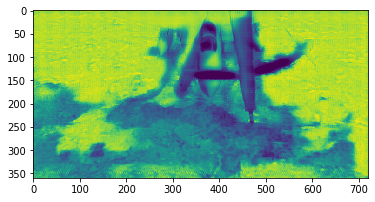

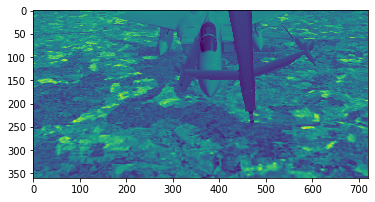

Saving file: AtoB_11.h5
>24301, dA[0.006,0.269] dB[0.006,0.011] g[1.021,1.122]
>24401, dA[0.006,0.269] dB[0.006,0.011] g[0.976,1.112]
>24501, dA[0.006,0.269] dB[0.006,0.011] g[2.564,2.190]
>24601, dA[0.006,0.269] dB[0.006,0.011] g[0.977,1.016]
>24701, dA[0.006,0.269] dB[0.006,0.011] g[0.824,0.903]
>24801, dA[0.006,0.269] dB[0.006,0.011] g[0.824,0.851]
>24901, dA[0.006,0.269] dB[0.006,0.011] g[0.798,0.911]
>25001, dA[0.006,0.269] dB[0.006,0.011] g[0.777,1.004]
>25101, dA[0.006,0.269] dB[0.006,0.011] g[2.847,2.514]
>25201, dA[0.006,0.269] dB[0.006,0.011] g[0.690,0.778]
>25301, dA[0.006,0.269] dB[0.006,0.011] g[0.808,1.103]
>25401, dA[0.006,0.269] dB[0.006,0.011] g[2.210,1.909]
>25501, dA[0.006,0.269] dB[0.006,0.011] g[0.839,1.172]
>25601, dA[0.006,0.269] dB[0.006,0.011] g[1.379,1.010]
>25701, dA[0.006,0.269] dB[0.006,0.011] g[1.160,1.104]
>25801, dA[0.006,0.269] dB[0.006,0.011] g[2.697,2.162]
>25901, dA[0.006,0.269] dB[0.009,0.065] g[1.516,1.547]
>26001, dA[0.006,0.269] dB[0.009,0.065] g

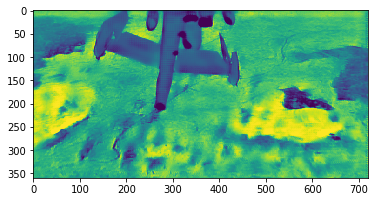

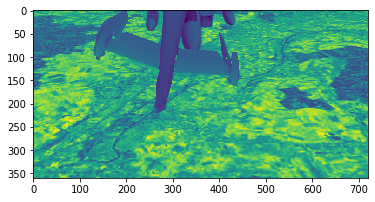

Saving file: AtoB_12.h5
>26501, dA[0.006,0.269] dB[0.026,0.050] g[1.203,0.920]
>26601, dA[0.006,0.269] dB[0.009,0.030] g[1.168,1.132]
>26701, dA[0.006,0.269] dB[0.009,0.030] g[2.015,2.018]
>26801, dA[0.006,0.269] dB[0.036,0.015] g[1.630,1.331]
>26901, dA[0.006,0.269] dB[0.015,0.081] g[1.537,1.056]
>27001, dA[0.006,0.269] dB[0.059,0.011] g[1.652,1.301]
>27101, dA[0.006,0.269] dB[0.008,0.011] g[1.572,1.483]
>27201, dA[0.006,0.269] dB[0.008,0.011] g[0.898,0.861]
>27301, dA[0.006,0.269] dB[0.069,0.015] g[1.400,1.076]
>27401, dA[0.006,0.269] dB[0.008,0.041] g[2.033,1.549]
>27501, dA[0.006,0.269] dB[0.008,0.041] g[0.971,0.972]
>27601, dA[0.006,0.269] dB[0.008,0.041] g[2.861,2.130]
>27701, dA[0.006,0.269] dB[0.008,0.041] g[0.837,1.013]
>27801, dA[0.006,0.269] dB[0.011,0.088] g[1.077,1.202]
>27901, dA[0.006,0.269] dB[0.013,0.148] g[1.750,1.279]
>28001, dA[0.006,0.269] dB[0.214,0.070] g[1.679,1.058]
>28101, dA[0.006,0.269] dB[0.008,0.102] g[1.173,1.036]
>28201, dA[0.006,0.269] dB[0.008,0.102] g

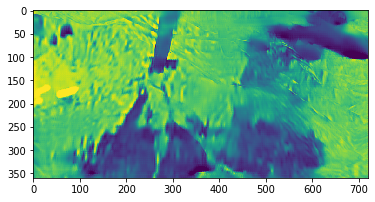

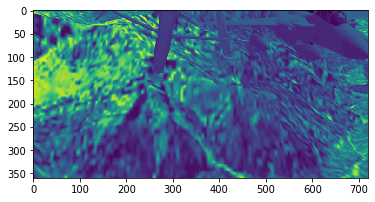

Saving file: AtoB_13.h5
>28701, dA[0.006,0.269] dB[0.012,0.062] g[2.209,1.303]
>28801, dA[0.006,0.269] dB[0.011,0.059] g[1.771,1.455]
>28901, dA[0.006,0.269] dB[0.020,0.067] g[1.674,1.169]
>29001, dA[0.006,0.269] dB[0.026,0.006] g[0.748,1.029]
>29101, dA[0.006,0.269] dB[0.026,0.006] g[1.576,1.302]
>29201, dA[0.006,0.269] dB[0.021,0.008] g[4.414,4.562]
>29301, dA[0.006,0.269] dB[0.021,0.008] g[0.895,0.837]
>29401, dA[0.006,0.269] dB[0.021,0.008] g[1.133,1.033]
>29501, dA[0.006,0.269] dB[0.012,0.147] g[1.237,1.249]
>29601, dA[0.006,0.269] dB[0.054,0.010] g[1.548,1.552]
>29701, dA[0.006,0.269] dB[0.017,0.058] g[1.740,1.289]
>29801, dA[0.006,0.269] dB[0.009,0.106] g[1.415,1.039]
>29901, dA[0.006,0.269] dB[0.033,0.051] g[1.989,1.656]
>30001, dA[0.006,0.269] dB[0.010,0.214] g[1.294,1.096]
>30101, dA[0.006,0.269] dB[0.021,0.052] g[1.277,1.025]
>30201, dA[0.006,0.269] dB[0.009,0.043] g[1.004,0.961]
>30301, dA[0.006,0.269] dB[0.012,0.184] g[1.906,1.869]
>30401, dA[0.006,0.269] dB[0.015,0.061] g

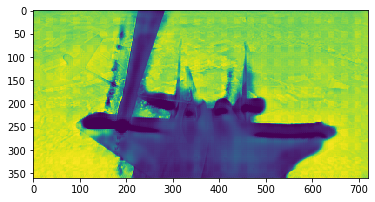

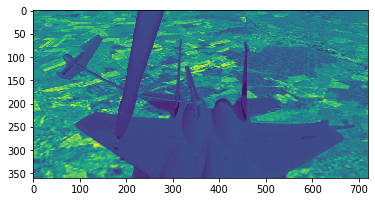

Saving file: AtoB_14.h5
>30901, dA[0.006,0.269] dB[0.011,0.107] g[2.283,2.111]
>31001, dA[0.006,0.269] dB[0.020,0.011] g[2.868,2.020]
>31101, dA[0.006,0.269] dB[0.021,0.015] g[1.577,1.129]
>31201, dA[0.006,0.269] dB[0.012,0.172] g[1.490,1.015]
>31301, dA[0.006,0.269] dB[0.017,0.031] g[1.520,1.172]
>31401, dA[0.006,0.269] dB[0.008,0.020] g[1.161,0.913]
>31501, dA[0.006,0.269] dB[0.008,0.020] g[1.013,1.346]
>31601, dA[0.006,0.269] dB[0.008,0.020] g[1.941,1.920]
>31701, dA[0.006,0.269] dB[0.008,0.020] g[0.859,0.872]
>31801, dA[0.006,0.269] dB[0.011,0.059] g[2.724,1.935]
>31901, dA[0.006,0.269] dB[0.010,0.124] g[2.500,1.754]
>32001, dA[0.006,0.269] dB[0.175,0.007] g[1.165,1.245]
>32101, dA[0.006,0.269] dB[0.175,0.007] g[1.194,1.327]
>32201, dA[0.006,0.269] dB[0.014,0.008] g[1.047,0.904]
>32301, dA[0.006,0.269] dB[0.009,0.014] g[1.344,1.590]
>32401, dA[0.006,0.269] dB[0.010,0.217] g[1.554,1.175]
>32501, dA[0.006,0.269] dB[0.010,0.029] g[1.234,0.962]
>32601, dA[0.006,0.269] dB[0.010,0.029] g

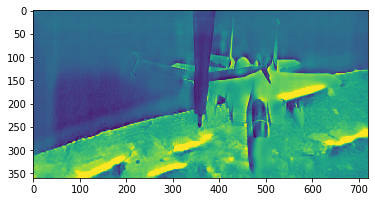

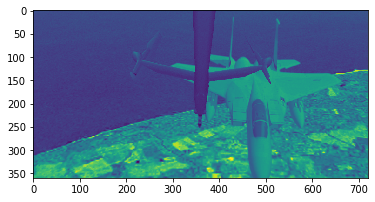

Saving file: AtoB_15.h5
>33101, dA[0.006,0.269] dB[0.141,0.012] g[1.350,1.095]
>33201, dA[0.006,0.269] dB[0.010,0.146] g[1.988,1.623]
>33301, dA[0.006,0.269] dB[0.010,0.146] g[1.473,1.176]
>33401, dA[0.006,0.269] dB[0.009,0.043] g[1.762,1.558]
>33501, dA[0.006,0.269] dB[0.009,0.043] g[1.433,1.026]
>33601, dA[0.006,0.269] dB[0.009,0.009] g[1.068,0.878]
>33701, dA[0.006,0.269] dB[0.032,0.076] g[2.011,2.163]
>33801, dA[0.006,0.269] dB[0.032,0.009] g[1.291,0.927]
>33901, dA[0.006,0.269] dB[0.050,0.009] g[1.383,1.185]
>34001, dA[0.006,0.269] dB[0.012,0.010] g[1.493,1.346]
>34101, dA[0.006,0.269] dB[0.015,0.009] g[1.881,1.694]
>34201, dA[0.006,0.269] dB[0.015,0.009] g[1.513,1.231]
>34301, dA[0.006,0.269] dB[0.015,0.009] g[1.950,1.547]
>34401, dA[0.006,0.269] dB[0.111,0.075] g[1.269,1.029]
>34501, dA[0.006,0.269] dB[0.007,0.016] g[1.556,1.270]
>34601, dA[0.006,0.269] dB[0.007,0.016] g[1.012,0.803]
>34701, dA[0.006,0.269] dB[0.007,0.016] g[1.070,1.341]
>34801, dA[0.006,0.269] dB[0.007,0.016] g

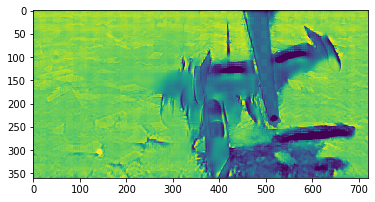

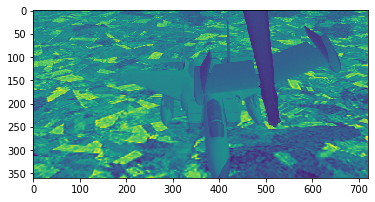

Saving file: AtoB_16.h5
>35301, dA[0.006,0.269] dB[0.193,0.264] g[1.481,1.097]
>35401, dA[0.006,0.269] dB[0.008,0.092] g[1.040,1.055]
>35501, dA[0.006,0.269] dB[0.006,0.032] g[1.298,1.014]
>35601, dA[0.006,0.269] dB[0.006,0.032] g[0.948,1.093]
>35701, dA[0.006,0.269] dB[0.006,0.032] g[0.724,0.775]
>35801, dA[0.006,0.269] dB[0.006,0.032] g[0.731,0.841]
>35901, dA[0.006,0.269] dB[0.006,0.032] g[0.806,0.987]
>36001, dA[0.006,0.269] dB[0.007,0.022] g[1.615,1.572]
>36101, dA[0.006,0.269] dB[0.007,0.022] g[3.063,2.722]
>36201, dA[0.006,0.269] dB[0.007,0.022] g[1.271,1.741]
>36301, dA[0.006,0.269] dB[0.007,0.022] g[1.509,1.856]
>36401, dA[0.006,0.269] dB[0.007,0.022] g[1.280,1.125]
>36501, dA[0.006,0.269] dB[0.007,0.022] g[0.795,0.814]
>36601, dA[0.006,0.269] dB[0.007,0.022] g[0.973,1.024]
>36701, dA[0.006,0.269] dB[0.008,0.064] g[1.365,0.845]
>36801, dA[0.006,0.269] dB[0.008,0.064] g[1.122,1.104]
>36901, dA[0.006,0.269] dB[0.008,0.064] g[1.323,1.563]
>37001, dA[0.006,0.269] dB[0.008,0.064] g

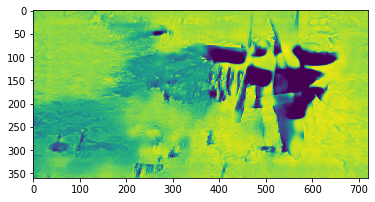

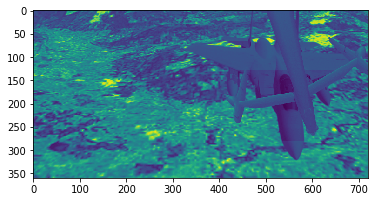

Saving file: AtoB_17.h5
>37501, dA[0.006,0.269] dB[0.009,0.020] g[1.799,2.032]
>37601, dA[0.006,0.269] dB[0.016,0.008] g[1.218,0.689]
>37701, dA[0.006,0.269] dB[0.016,0.008] g[1.255,0.884]
>37801, dA[0.006,0.269] dB[0.013,0.015] g[2.279,1.506]
>37901, dA[0.006,0.269] dB[0.023,0.009] g[2.152,1.512]
>38001, dA[0.006,0.269] dB[0.009,0.219] g[1.378,1.324]
>38101, dA[0.006,0.269] dB[0.066,0.045] g[3.213,2.241]
>38201, dA[0.006,0.269] dB[0.182,0.089] g[1.297,0.897]
>38301, dA[0.006,0.269] dB[0.102,0.163] g[1.126,0.855]
>38401, dA[0.006,0.269] dB[0.005,0.105] g[1.790,1.457]
>38501, dA[0.006,0.269] dB[0.005,0.105] g[1.643,1.149]
>38601, dA[0.006,0.269] dB[0.005,0.105] g[0.977,0.824]
>38701, dA[0.006,0.269] dB[0.005,0.105] g[1.602,1.566]
>38801, dA[0.006,0.269] dB[0.005,0.105] g[0.996,1.048]
>38901, dA[0.022,0.007] dB[0.005,0.105] g[2.125,1.870]
>39001, dA[0.022,0.007] dB[0.005,0.105] g[1.409,2.321]
>39101, dA[0.008,0.333] dB[0.005,0.105] g[2.269,2.072]
>39201, dA[0.008,0.333] dB[0.005,0.105] g

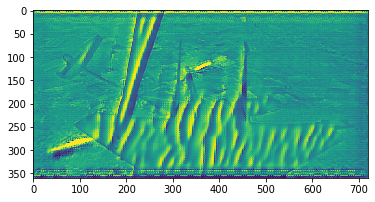

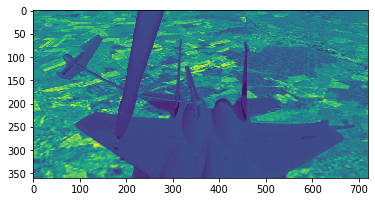

Saving file: AtoB_18.h5
>39701, dA[0.066,0.060] dB[0.005,0.105] g[1.407,1.992]
>39801, dA[0.009,0.028] dB[0.005,0.105] g[1.495,1.580]
>39901, dA[0.009,0.174] dB[0.005,0.105] g[2.369,2.193]
>40001, dA[0.010,0.018] dB[0.005,0.105] g[1.367,1.951]
>40101, dA[0.031,0.033] dB[0.005,0.105] g[0.713,0.932]
>40201, dA[0.014,0.130] dB[0.005,0.105] g[2.581,3.990]
>40301, dA[0.117,0.008] dB[0.005,0.105] g[0.766,1.139]
>40401, dA[0.033,0.012] dB[0.005,0.105] g[3.084,3.542]
>40501, dA[0.061,0.010] dB[0.005,0.105] g[1.126,1.843]
>40601, dA[0.013,0.080] dB[0.005,0.105] g[0.725,1.852]
>40701, dA[0.018,0.183] dB[0.005,0.105] g[1.042,1.310]
>40801, dA[0.104,0.127] dB[0.005,0.105] g[0.785,1.378]
>40901, dA[0.103,0.145] dB[0.005,0.105] g[0.676,0.900]
>41001, dA[0.075,0.007] dB[0.005,0.105] g[0.849,1.245]
>41101, dA[0.075,0.007] dB[0.005,0.105] g[0.734,0.905]
>41201, dA[0.075,0.007] dB[0.005,0.105] g[0.686,0.907]
>41301, dA[0.012,0.020] dB[0.005,0.105] g[1.183,1.483]
>41401, dA[0.081,0.009] dB[0.005,0.105] g

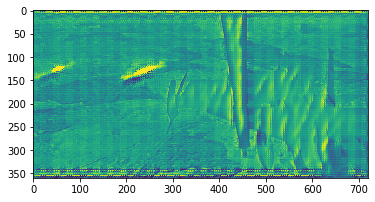

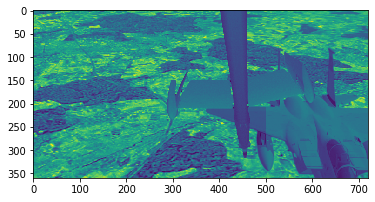

Saving file: AtoB_19.h5
>41901, dA[0.153,0.094] dB[0.005,0.105] g[0.709,1.552]
>42001, dA[0.266,0.333] dB[0.005,0.105] g[0.947,1.346]
>42101, dA[0.020,0.086] dB[0.005,0.105] g[1.025,2.046]
>42201, dA[0.024,0.009] dB[0.005,0.105] g[1.004,1.223]
>42301, dA[0.169,0.449] dB[0.005,0.105] g[0.719,0.919]
>42401, dA[0.013,0.007] dB[0.005,0.105] g[2.512,2.726]
>42501, dA[0.013,0.007] dB[0.005,0.105] g[0.825,1.036]
>42601, dA[0.137,0.007] dB[0.005,0.105] g[0.852,1.238]
>42701, dA[0.137,0.007] dB[0.005,0.105] g[2.035,1.687]
>42801, dA[0.137,0.007] dB[0.005,0.105] g[0.671,0.774]
>42901, dA[0.028,0.107] dB[0.005,0.105] g[0.828,1.080]
>43001, dA[0.086,0.010] dB[0.005,0.105] g[1.062,1.340]
>43101, dA[0.014,0.008] dB[0.005,0.105] g[0.734,0.895]
>43201, dA[0.033,0.011] dB[0.005,0.105] g[0.730,1.202]
>43301, dA[0.007,0.236] dB[0.005,0.105] g[2.569,3.088]
>43401, dA[0.007,0.236] dB[0.005,0.105] g[0.760,1.046]
>43501, dA[0.007,0.236] dB[0.005,0.105] g[0.799,1.027]
>43601, dA[0.007,0.236] dB[0.005,0.105] g

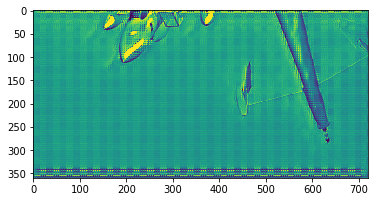

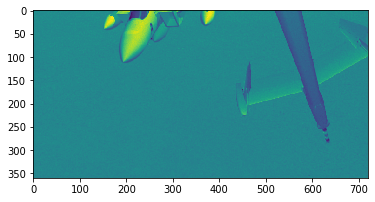

Saving file: AtoB_20.h5
>44101, dA[0.044,0.005] dB[0.005,0.105] g[0.917,1.359]
>44201, dA[0.044,0.005] dB[0.005,0.105] g[0.620,0.831]
>44301, dA[0.044,0.005] dB[0.005,0.105] g[0.735,0.903]
>44401, dA[0.044,0.005] dB[0.005,0.105] g[0.691,0.776]
>44501, dA[0.044,0.005] dB[0.005,0.105] g[0.606,0.727]
>44601, dA[0.044,0.005] dB[0.005,0.105] g[1.515,1.596]
>44701, dA[0.044,0.005] dB[0.011,0.015] g[2.321,1.730]


In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, (trainA,trainB))

In [ ]:
for i in range(46,47):
    plt.figure(figsize=(9,12))
    plt.imshow(np.squeeze(normalize(g_model_AtoB.predict(np.expand_dims(testA[i,:,:], 0))))[50:200, 0:200], cmap = 'gray')
    plt.show()

In [9]:
from keras.models import load_model
model = load_model('AtoB_50.h5', custom_objects = {'InstanceNormalization':InstanceNormalization})

/home/tkyono/.local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


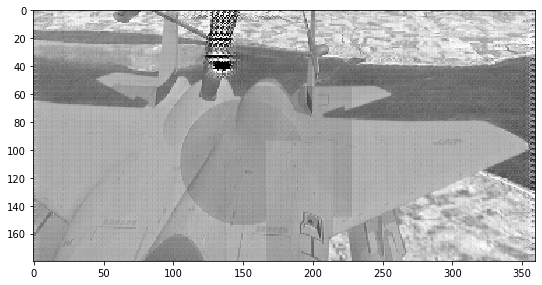

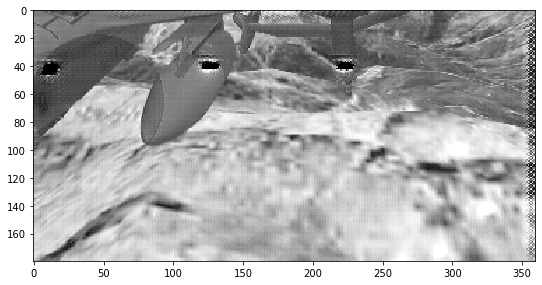

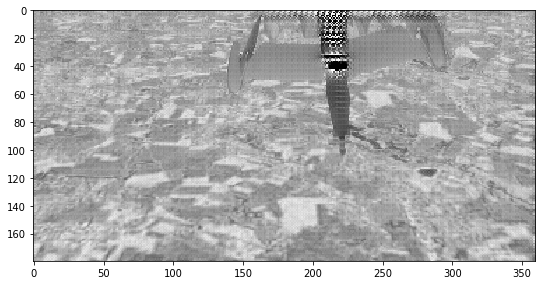

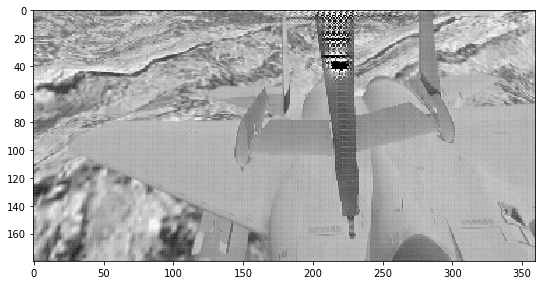

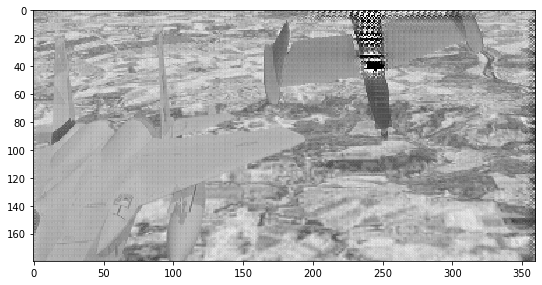

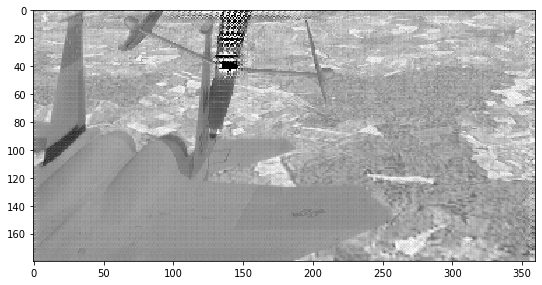

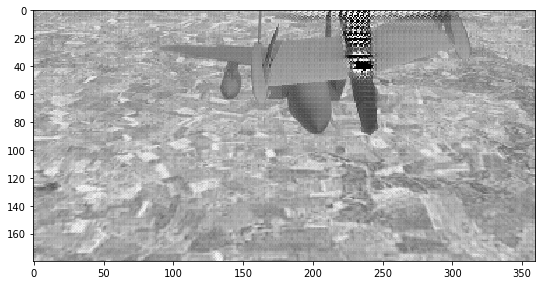

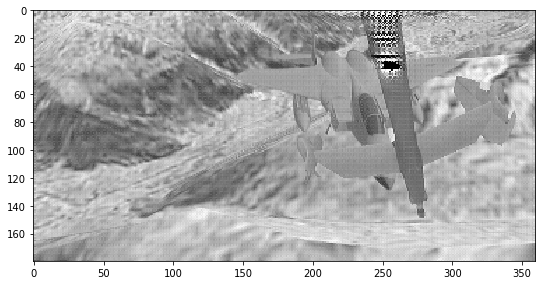

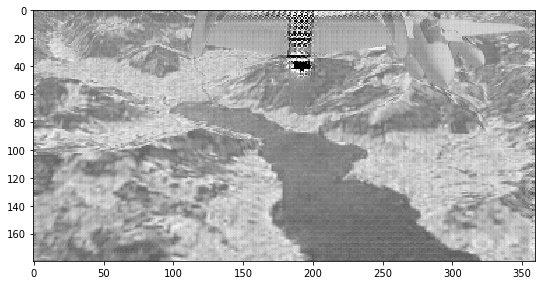

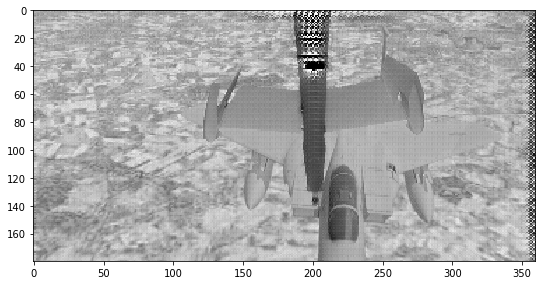

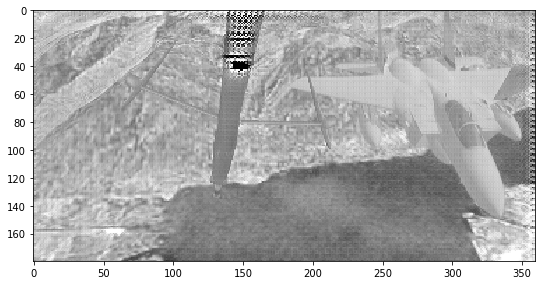

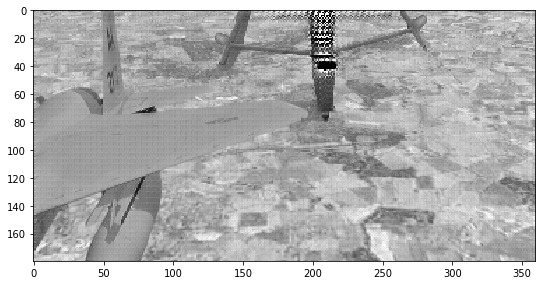

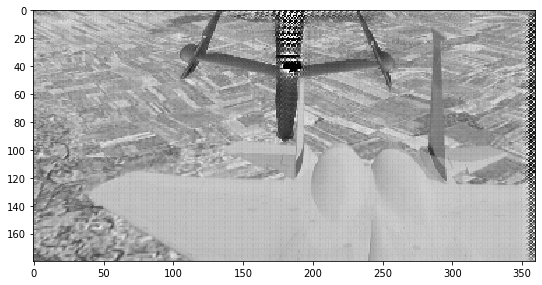

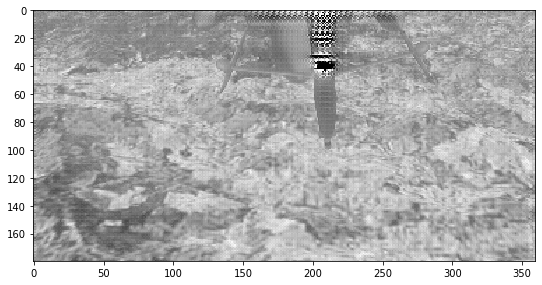

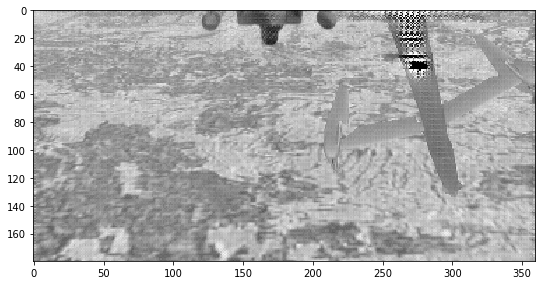

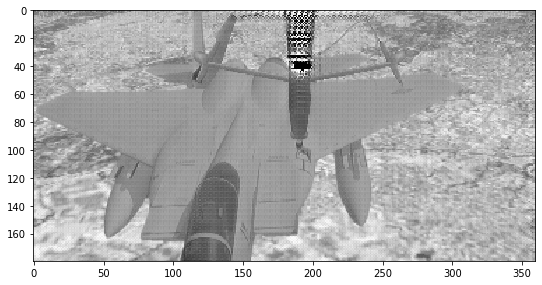

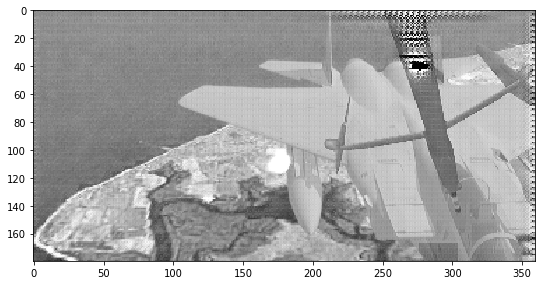

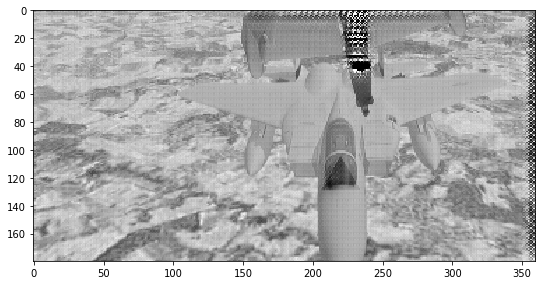

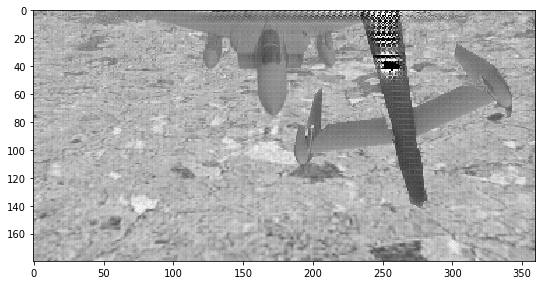

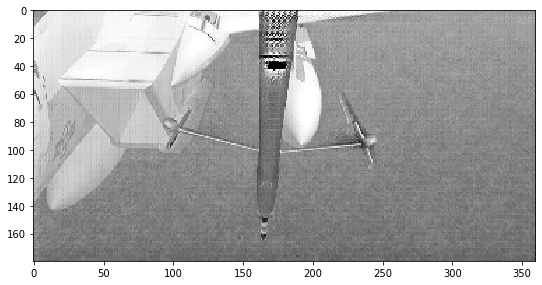

In [10]:
for i in range(0,20):
    plt.figure(figsize=(9,12))
    plt.imshow(np.squeeze(normalize(model.predict(np.expand_dims(testA[i,:,:], 0)))), cmap = 'gray')
    plt.show()